<a href="https://colab.research.google.com/github/AnirudhSinghBhadauria/pyspark/blob/main/crypto_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [98]:
import time
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark import StorageLevel
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.window import Window

In [99]:
spark = SparkSession.builder.appName('crypto-test').getOrCreate()

In [113]:
crypto_df = (
    spark.read.format("csv")
    .option("mode", "FAILFAST")
    .option("inferSchema", "true")
    .option("skipRows", 0)
    .option("header", "true")
    .load("drive/MyDrive/crypto_tradinds.csv")
)

In [114]:
unwanted_columns = [
    'site_url',
    'github_url',
    'crypto_type',
    'BTC_price_change_1_day',
    'industry_name',
    'price_btc'
]

crypto_df = crypto_df.select(
    [column for column in crypto_df.columns if column not in unwanted_columns]
)

In [115]:
# crypto_df = crypto_df.dropDuplicates()

In [116]:
def remove_outliers(df, group_col, target_col):
    quantiles = df.groupBy(group_col).agg(
        expr(f"percentile_approx({target_col}, 0.25)").alias("Q1"),
        expr(f"percentile_approx({target_col}, 0.75)").alias("Q3")
    )

    quantiles = quantiles.withColumn("IQR", col("Q3") - col("Q1")) \
                         .withColumn("lower_bound", col("Q1") - 1.5 * col("IQR")) \
                         .withColumn("upper_bound", col("Q3") + 1.5 * col("IQR"))

    df_with_bounds = df.join(quantiles, on=group_col, how="left")

    cleaned_df = df_with_bounds.filter(
        (col(target_col) >= col("lower_bound")) &
        (col(target_col) <= col("upper_bound"))
    ).drop("Q1", "Q3", "IQR", "lower_bound", "upper_bound")

    return cleaned_df

crypto_df = remove_outliers(crypto_df, "crypto_name", "price_usd")

In [117]:
crypto_df.persist(StorageLevel.MEMORY_ONLY)

DataFrame[crypto_name: string, trade_date: date, volume: double, price_usd: double, market_cap: double, capitalization_change_1_day: double, USD_price_change_1_day: double, ticker: string, max_supply: bigint, minable: int, platform_name: string]

In [118]:
(
    crypto_df
    .select("crypto_name")
    .distinct()
    .sample(fraction=0.0001)
    # .show()
)

DataFrame[crypto_name: string]

In [119]:
def get_crypto(ticker_name: str):
  crypto_df.filter(
      col("ticker") == ticker_name
  ).show()

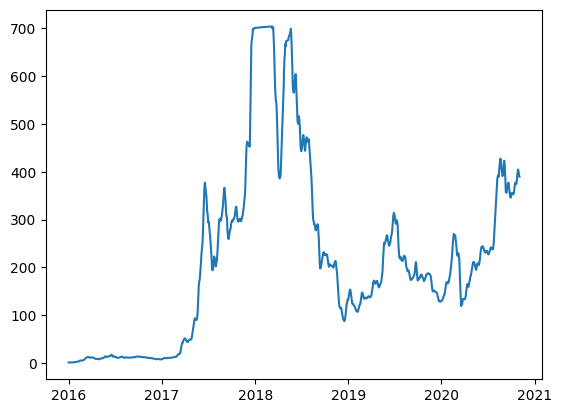

In [221]:
# @title Rolling Averages for any crypto currency!
ticker = "ETH" # @param {"type":"string","placeholder":"Enter ticker tag of the crypto"}
def rolling_average(currency, days):
  window = (Window.orderBy("trade_date").rowsBetween(-(days), 0))

  rolling_average_currency = (
      crypto_df
      .filter(
          col("ticker") == currency
      )
      .withColumn(
          "rolling_average",
          round(avg("price_usd").over(window), 3)
      )
  )

  y_value = [ravg.rolling_average for ravg in rolling_average_currency.select("rolling_average").collect()]
  x_value = [tdate.trade_date for tdate in rolling_average_currency.select("trade_date").collect()]

  plt.plot(x_value, y_value)
  plt.show()

rolling_average(ticker, 6)

In [122]:
# (
#   crypto_df
#   .select(["ticker", "crypto_name"])
#   .distinct()
#   .sample(fraction = 0.5)
#   .show(n = crypto_df.count(), truncate = False)
# )

In [ ]:
# @title Get current price of selected cryptos
def get_price_inr(usd_price):
    try:
        response = requests.get(
            "https://anyapi.io/api/v1/exchange/convert",
            params={
                'base': 'USD',
                'to': 'INR',
                'amount': usd_price,
                'apiKey': '6ht7uuqsuro70e9fpp7lioi3vnie9j5sos70fd4i6j0ooloj2q4t1j'
            },
            timeout=10
        )
        response.raise_for_status()
        return response.json().get('converted')
    except requests.RequestException as e:
        print(f"Error converting price: {e}")
        return None

def ticker():
    coins_to_fetch = {
        'Bitcoin', 'Ethereum', 'Solana', 'Sui',
        'Dogecoin', 'Polygon Ecosystem Token'
    }

    try:
        response = requests.get(
            "https://api.coinpaprika.com/v1/tickers/",
            timeout=10
        )
        response.raise_for_status()
        data = response.json()
    except requests.RequestException as e:
        print(f"Error fetching tickers: {e}")
        return []

    processed_coins = []

    with ThreadPoolExecutor() as executor:
        future_to_coin = {
            executor.submit(process_coin, coin): coin for coin in data if coin['name'] in coins_to_fetch
        }

        for future in as_completed(future_to_coin):
            coin = future_to_coin[future]
            try:
                processed_coin = future.result()
                if processed_coin:
                    processed_coins.append(processed_coin)
            except Exception as e:
                print(f"Error processing coin {coin['name']}: {e}")

    return processed_coins

def process_coin(coin):
    processed_coin = coin.copy()
    usd_price = coin['quotes']['USD']['price']
    processed_coin['quotes']['INR'] = get_price_inr(usd_price)
    return processed_coin

if __name__ == "__main__":
    crypto_data = ticker()

    crypto_extracted_df = spark.createDataFrame(crypto_data)
    crypto_extracted_df = crypto_extracted_df.select(
      "name", "symbol", "rank", "total_supply",
      "max_supply", "last_updated",
      col("quotes.USD.price").alias("usd_price"),
      col("quotes.USD.volume_24h").alias("usd_volume_24h"),
      col("quotes.USD.market_cap").alias("usd_market_cap"),
      col("quotes.INR").alias("inr_price")
    )

crypto_extracted_df.show()

In [195]:
# @title Find the average Market cap and price of any currency for year 2016 - 2021
def find_avg_marketcap(ticker: str):
    result = (
        crypto_df
        .filter(col("ticker") == ticker)
        .agg(
            round(avg("market_cap"), 3).alias("avg_market_cap"),
            round(avg("price_usd"), 3).alias("price_usd")
        )
        .first()
    )

    return (
        result["avg_market_cap"],
        result["price_usd"]
    )

find_avg_marketcap("ETH")

(19905058804.732, 193.797)

In [218]:
# @title Top 5 most volatile crypto currencies in 2016 - 2021
(
    crypto_df
    .select(["crypto_name", "USD_price_change_1_day"])
    .groupBy("crypto_name")
    .agg(avg(col("USD_price_change_1_day")).alias("avg_price_change ($)"))
    .withColumn("avg_price_change ($)", round(col("avg_price_change ($)"), 3))
    .sort(col("avg_price_change ($)").desc())
    .show(5, truncate=False)
)

+---------------------------+--------------------+
|crypto_name                |avg_price_change ($)|
+---------------------------+--------------------+
|Innovative Bioresearch Coin|72320.864           |
|Krosscoin                  |180.846             |
|NewYorkCoin                |105.285             |
|Veritaseum                 |61.275              |
|MoonSwap                   |34.651              |
+---------------------------+--------------------+
only showing top 5 rows



In [194]:
crypto_df.printSchema()

root
 |-- crypto_name: string (nullable = true)
 |-- trade_date: date (nullable = true)
 |-- volume: double (nullable = true)
 |-- price_usd: double (nullable = true)
 |-- market_cap: double (nullable = true)
 |-- capitalization_change_1_day: double (nullable = true)
 |-- USD_price_change_1_day: double (nullable = true)
 |-- ticker: string (nullable = true)
 |-- max_supply: long (nullable = true)
 |-- minable: integer (nullable = true)
 |-- platform_name: string (nullable = true)

